In [34]:
from numpy import *
from scipy.optimize import fsolve
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
%matplotlib inline

2. The following catalyzed gas phase reaction is studied in a packed bed reactor:
\begin{equation}
A + 2B \rightarrow C
\end{equation}


The reaction is zero order with respect to $A$ and first order with respect to the partial pressure of $B$. The specific rate constant ($k^{'}$) at $170^{\circ}C$ (the reactor temperature) is given as $0.05~\dfrac{mol~A}{kg.minute.atm_{B}}$. The total molar feed flow rate is $40~mol/min$ ($33\%~A$ and $67\%~B$). The inlet pressure is $5~atm$.

**Additional information:**

- Average molecular weight of inlet – $30 g/mol$
- Bed porosity – $0.4$
- Reactor diameter – $0.085~m$
- Catalyst diameter – $3~mm$
- Gas viscosity – $2e-5~kg/ms$
- Packed bed density – $1000~kg/m3$


**Note:** PLEASE do not confuse the bed density $\rho_{B}$ with the GAS density at the inlet $\rho_{0}$. The bed density is needed to convert the units of the Ergun equation from $\dfrac{P_{a}}{m}$ to $\dfrac{P_{a}}{kg}$  while the gas density is one of the parameters in the Ergun equation.

**Hints:**
- Rate expressions of gas phase reactions are often expressed in terms of the partial pressures of the reactants instead of the concentration.–of course there is a direct link. This is true in this case. In addition the rate of depletion of $A$ is first order in terms of the partial pressure of $B$: $-r_{a}^{’} = k^{’}p_{B} = -k^{’}y_{B}P= -k^{’}( F_{B}/F_{T})P$, with variables $F_{B}$, $P$, and $F_{T} = F_{A} + F_{B} + F_{C}$
- It is a good exercise to reduce the number of variables to two ($X_{A}$ and $P$) AND to see if you can solve it if you keep the number of variables ($4$) as specified above. In each case the number of differential equations needs to match the number of variables.
- Note that the Ergun equations for **isothermal gas phase flow** in a packed bed can be written as $\dfrac{dP}{dW} = -K\dfrac{P_{0}}{P} \dfrac{F_{T}}{F_{T_{0}}} $. This is true if we use the ideal gas law to get the gas density in terms of the dependent variables $𝑃$,$𝑇$,$𝐹_{T}$ Careful with the units!!! In the rate expression P must be in $atm$ in the given rate equation, while the $P$ in the Ergun equation is in $P_{a}$ if all the parameters in $K$ are substituted in SI units. In SI units I get a value of: $K = 3184.4~P_{a}.kg^{-1}$ if I DO NOT apply the turbulent flow simplification.
- Use a termination event in solve_ivp to make sure the pressure does not fall below zero – this will give you CRAZY profiles. In fact, you can specify more than one termination event. Add one that stops the integration as soon as the conversion reaches $60\%$.

-----------------------------------------------------------

In [35]:
Fto     =                40/60 #mol/s
FAo     =             0.33*Fto #mol/s
FBo     =             0.67*Fto #mol/s
FCo     =                    0 #mol/s
Po      =            5*101.325 #kpa

In [36]:
#given:
T       =         170 + 273.15 #Kelvin
R       =           8.314/1000 #kpa.m3/mol.K
MMav    =                0.030 #kg/mol
epsilon =                  0.4 #m3/m3 bed porosity(Vopen/Vtot)
Dreact  =                0.085 #m reactor diameter
Aacross = (22/7)*(Dreact**2)/4 #m2 cross-sectional area
dcat    =                0.003 #m
mu      =                 2e-5 #kg/m/s fluid viscosity 
rhobed  =                 1000 #kg/m^3 packed bed density
rhocat  =   rhobed/(1-epsilon)
rhoinit =      (Po*MMav)/(R*T)
Kprime  =     0.05/(60*101325) #molA/kg/s/pascalB

In [37]:
G = (MMav*Fto)/Aacross #kg/m2.s
K = (G/(rhoinit*dcat))*((1-epsilon)/(epsilon**3))*(150*mu*(1-epsilon)/dcat + 1.75*G)/(Aacross*rhocat*(1-epsilon))
print(G)
print(K)

3.5231204781377783
3180.718993486767


**a) Neglecting pressure drop, obtain the concentration- and reaction rate profiles as a function of catalyst mass. Give all the relevant values at a conversion of $A$ of $60$%. Also give the mass of catalyst required to give a conversion of $60$%.**

In [38]:
#a) assuming constant pressure Ptot = 5atm
#Xa = 1
#FA = FAo*(1-Xa)
#FB = FBo - 2*FAo*Xa
#FC = FCo + FAo*Xa
#Ftot = FA + FB + FC

In [39]:
def alg(F):
    FA, FB, FC = F    
    Ftot = F[0] + F[1] + F[2]
    Q = Ftot*R*T/Po
    CA = FA*Po/(Ftot*R*T)
    CB = FB*Po/(Ftot*R*T)
    CC = FC*Po/(Ftot*R*T)
    rAprime = -Kprime*FB*Po*1000/Ftot #remember to change P to pascals
    rBprime = 2*rAprime
    rCprime = -rAprime
    
    return[rAprime,rBprime,rCprime,Q,CA,CB,CC,Ftot] 

In [40]:
def diffs(F,W):
    FA, FB, FC = F[0], F[1], F[2]
    var = alg([FA,FB,FC])
    dFAdW = var[0]
    dFBdW = var[1]
    dFCdW = var[2]
    return[dFAdW,dFBdW,dFCdW]

In [41]:
Fo = [FAo,FBo,FCo]
W = 55.4 #in Kg. Keep changing until XA=0.6
wspan = linspace(0,W,100)
F = odeint(diffs,Fo,wspan)
FA,FB,FC = F.T

XA = (FAo - FA[-1])/FAo

print(XA)
print('W= ',W,'kg catalyst')
print('Pressure is kept constant at ',Po/101.325,'atm')

0.600982748204946
W=  55.4 kg catalyst
Pressure is kept constant at  5.0 atm


In [42]:
var = asarray([alg(F) for F in F]) # F is results from odeint
rA = var[:,0]
rB = var[:,1]
rC = var[:,2]
CA = var[:,4]
CB = var[:,5]
CC = var[:,6]

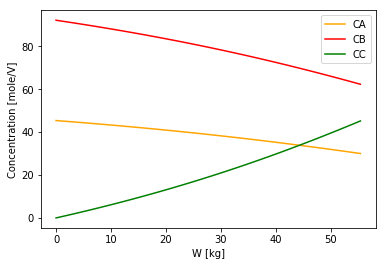

In [43]:
plt.figure(1)
plt.plot(wspan, CA, color='orange', label='CA')
plt.plot(wspan, CB, color='red',label='CB')
plt.plot(wspan, CC, color='green',label='CC')
plt.legend(loc='best')
plt.ylabel('Concentration [mole/V]') 
plt.xlabel('W [kg]') 
plt.show()

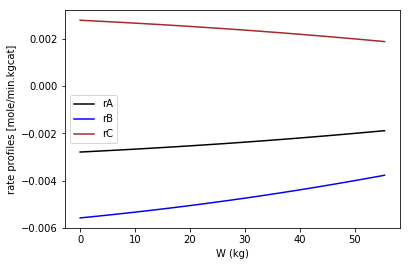

In [44]:
plt.figure(2)
plt.plot(wspan, rA, color='black', label='rA')
plt.plot(wspan, rB, color='blue',label='rB')
plt.plot(wspan, rC, color='brown',label='rC')
plt.legend(loc='best')
plt.ylabel('rate profiles [mole/min.kgcat]') 
plt.xlabel('W (kg)') 
plt.show()

**b) What is the effect of pressure drop on the results in (a)? Add a plot of the pressure in the reactor as a function of catalyst mass to your results. Compare the values of the independent variables with the scenario in a) at a conversion (of A) of $60$% Once again determine the catalyst mass at this point. Explain the differences.**

In [45]:
def diffs_pdrop(X,W):
    FA, FB, FC, P = X
    Ftot          = FA + FB + FC
    rAprime       = -Kprime*FB*P/Ftot
    rBprime       = 2*rAprime
    rCprime       = -rAprime
    dFAdW         = rAprime
    dFBdW         = rBprime
    dFCdW         = rCprime
    dPdW          = -K*(Po*1000/P)*(Ftot/Fto)
    return[dFAdW,dFBdW,dFCdW,dPdW]

In [46]:
Vals           = [FAo,FBo,FCo,Po*1000]
Wa             = 70.6#in Kg. Keep changing until XA=0.6
waspan         = linspace(0,Wa,100)
sol            = odeint(diffs_pdrop,Vals,waspan)
FA1,FB1,FC1,P1 = sol.T

XA1 = (FAo - FA1[-1])/FAo

print('conversion=', XA1*100,'%')
print('W= ',Wa,'kg catalyst')  
print('P@60%conv=',P1[-1]/101325,'atm')

conversion= 60.00482939415116 %
W=  70.6 kg catalyst
P@60%conv= 2.8113957452497913 atm


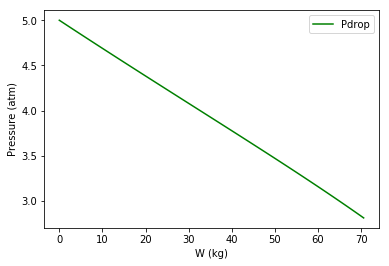

In [47]:
plt.figure(3)
plt.plot(waspan, P1/101325, color = 'green', label = 'Pdrop')
plt.xlabel('W (kg)')
plt.ylabel('Pressure (atm)')
plt.legend(loc='best')
#plt.grid()
plt.show()